# Fast Pagerank Implementation (Moler PageRank)
I needed a fast PageRank for Wikisim project, it has to be fast enough that can run in real time on relatively small graphs. I started from optimizing the networkx, wowever, I found a very nice algorithm algorithms by **Cleve Mole** which takes the full advantage of sparse matrix operations. 
Two implemenations are provided, both inspired  by the sparse fast solutions given in **Cleve Moler**'s book, [*Experiments with MATLAB*](http://www.mathworks.com/moler/index_ncm.html). The power method is much faster with enough precision for our task. Our benchmarsk shows that this implementation is **faster than networkx** implementation magnititude of times

The input is a 2d array, each row of the array is an edge of the graph [[a,b], [c,d]], a and b are the node numbers. 
## Comparison with Networkx
Both of the implementation (Exact Solution and PowerMethod) are much faster than their correspondent method in Network X


In [9]:
"""Two "fast" implementations of PageRank.

Pythom implementations of Matlab original in Cleve Moler, Experiments with MATLAB.
"""
# uncomment

import scipy as sp
import scipy.sparse as sprs
import scipy.spatial
import scipy.sparse.linalg 


__author__ = "Armin Sajadi"
__copyright__ = "Copyright 215, The Wikisim Project"
__credits__ = ["Armin Sajadi"]
__license__ = "GPL"
__version__ = "1.0.1"
__maintainer__ = "Armin Sajadi"
__email__ = "sajadi@cs.dal.ca"
__status__ = "Development"


def create_csr(Z):
    """ Creates a csr presentation from 2darray presentation
    Args:
        Z: input graph in the form of a 2d array, such as sp.array([[2,0], [1,2], [2,1]])
    Returns:
        a csr representation
    
    """   
    rows = Z[:,0];
    cols = Z[:,1];
    n = max(max(rows), max(cols))+1;
    G=sprs.csr_matrix((sp.ones(rows.shape),(rows,cols)), shape=(n,n));
    return G

def moler_pagerank_sparse(G, p=0.85, personalize=None, reverse=False):
    """ Calculates pagerank given a csr graph
    
    Args:
        G: a csr graph.
        p: damping factor
        personlize: if not None, should be an array with the size of the nodes
                    containing probability distributions. It will be normalized automatically
        reverse: If true, returns the reversed-pagerank 
        
    Returns:
        Pagerank Scores for the nodes
     
    """

    if not reverse:
        G=G.T;

    n,n=G.shape
    c=sp.asarray(G.sum(axis=0)).reshape(-1)
    r=sp.asarray(G.sum(axis=1)).reshape(-1)

    k=c.nonzero()[0]

    D=sprs.csr_matrix((1/c[k],(k,k)),shape=(n,n))

    if personalize is None:
        e=sp.ones((n,1))
    else:
        e = personalize/sum(personalize);
        
    I=sprs.eye(n)
    X1 = sprs.linalg.spsolve((I - p*G.dot(D)), e);

    X1=X1/sum(X1)
    return X1
def moler_pagerank_sparse_power(G, p=0.85, max_iter = 100,  tol=1e-06,personalize=None, reverse=False):
    """ Calculates pagerank given a csr graph
    
    Args:
        G: a csr graph.
        p: damping factor
        max_iter: maximum number of iterations
        personlize: if not None, should be an array with the size of the nodes
                    containing probability distributions. It will be normalized automatically
        reverse: If true, returns the reversed-pagerank 
        
    Returns:
        Pagerank Scores for the nodes
     
    """
    
    if not reverse: 
        G=G.T;

    n,n=G.shape
    c=sp.asarray(G.sum(axis=0)).reshape(-1)
    r=sp.asarray(G.sum(axis=1)).reshape(-1)

    k=c.nonzero()[0]

    D=sprs.csr_matrix((1/c[k],(k,k)),shape=(n,n))

    if personalize is None:
        e=sp.ones((n,1))
    else:
        e = personalize/sum(personalize);
        
    z = (((1-p)*(c!=0) + (c==0))/n)[sp.newaxis,:]
    G = p*G.dot(D)
    x = e/n
    oldx = sp.zeros((n,1));
    
    iteration = 0
    
    while sp.linalg.norm(x-oldx) > tol:
        oldx = x
        x = G.dot(x) + e.dot(z.dot(x))
        iteration += 1
        if iteration >= max_iter:
            break;
    x = x/sum(x)
    
    return x.reshape(-1)

# Benchmarking

In [2]:
import networkx as nx
import random
import timeit
n=5
min_size=1000
max_size=3000
m=20
size_vector=sp.zeros(m)
netx_pagerank=sp.zeros(m)
netx_pagerank_numpy=sp.zeros(m)
netx_pagerank_scipy=sp.zeros(m)
moler_pagerank=sp.zeros(m)
moler_pagerank_power=sp.zeros(m)

for i in range(m):
    G_size = random.randint(min_size,max_size)
    p=random.uniform(0.1, 0.5)
    G=nx.fast_gnp_random_graph(G_size, p, seed=None, directed=True)
    size_vector[i] = G.number_of_edges()
    A=nx.to_scipy_sparse_matrix(G)
    netx_pagerank[i] = timeit.timeit(lambda: nx.pagerank(G, alpha=0.85, tol=1e-03), number=n)/n
    netx_pagerank_numpy[i] = timeit.timeit(lambda: nx.pagerank_numpy(G, alpha=0.85), number=n)/n
    netx_pagerank_scipy[i] = timeit.timeit(lambda: nx.pagerank_scipy(G, alpha=0.85, tol=1e-03), number=n)/n
    moler_pagerank[i] = timeit.timeit(lambda: moler_pagerank_sparse(A, p=0.85), number=n)/n
    moler_pagerank_power[i] = timeit.timeit(lambda: moler_pagerank_sparse_power(A, p=0.85, tol=1e-03), number=n)/n

# Comparing Exact Methods
The comparison might not be fare though, we solve a linear equation and `networkx.page_rank_numpy` calculates the eigen vector. 

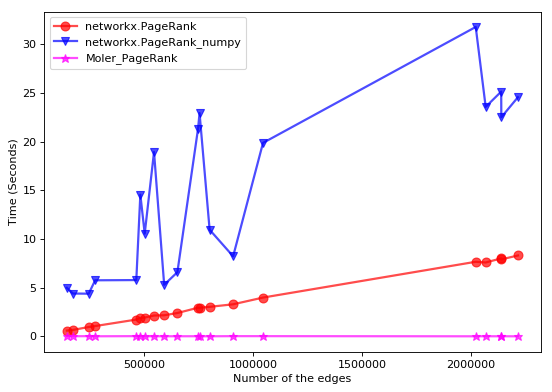

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(num=None, figsize=(7, 5), dpi=80, facecolor='w', edgecolor='k')

argsort = size_vector.argsort()

size_vector_sorted = size_vector[argsort]
netx_pagerank_sorted = netx_pagerank[argsort]
netx_pagerank_numpy_sorted = netx_pagerank_numpy[argsort]
moler_pagerank_sorted = moler_pagerank[argsort]



plt.plot(size_vector_sorted, netx_pagerank_sorted, 'o-',  ms=8, lw=2,alpha=0.7, color='red', label='networkx.PageRank')
plt.plot(size_vector_sorted, netx_pagerank_numpy_sorted, 'v-', ms=8, lw=2,alpha=0.7, color='blue', label='networkx.PageRank_numpy')
plt.plot(size_vector_sorted, moler_pagerank, '*-', ms=8, lw=2,alpha=0.7, color='magenta', label='Moler_PageRank')

plt.xlabel('Number of the edges')
plt.ylabel('Time (Seconds)')


plt.tight_layout()
plt.legend(loc=2)
plt.savefig('pagerank_exact.eps')
plt.show()


# Comparing Approximation Methods (Power Methods)

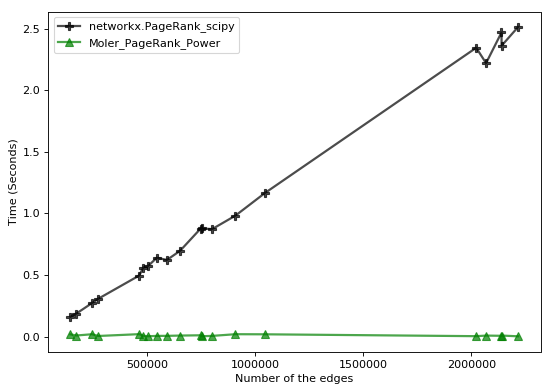

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(num=None, figsize=(7, 5), dpi=80, facecolor='w', edgecolor='k')

argsort = size_vector.argsort()

size_vector_sorted = size_vector[argsort]
netx_pagerank_scipy_sorted = netx_pagerank_scipy[argsort]
moler_pagerank_power_sorted = moler_pagerank_power[argsort]



plt.plot(size_vector_sorted, netx_pagerank_scipy_sorted, 'P-', ms=8, lw=2,alpha=0.7, color='black', label='networkx.PageRank_scipy')
plt.plot(size_vector_sorted, moler_pagerank_power, '^-', ms=8, lw=2,alpha=0.7, color='green', label='Moler_PageRank_Power')

plt.xlabel('Number of the edges')
plt.ylabel('Time (Seconds)')


plt.tight_layout()
plt.legend(loc=2)
plt.savefig('pagerank.eps')
plt.show()
